# **Projeto Quality Checker Kyndryl**
 
## **Made by Vìtor Ribeiro**

In [ ]:
# !apt-get install python3-distutils
!pip install pyfiglet
!pip install pandas


In [ ]:
import pandas as pd
import re
import json
from pyfiglet import Figlet
from distutils.util import strtobool
from datetime import datetime

f = Figlet(width=150)
print(f.renderText("Script made by\nVitor R. G. Gomes - Kyndryl\n2021-2022"))

In [ ]:
df = pd.read_excel("./Test Report Quality.xlsx")
pd.set_option("display.max_colwidth", None)
df2 = df.groupby("Number")
df2.head()

In [ ]:
df['Assigned To'].unique()

In [ ]:
len(df2.groups.keys())

In [ ]:
def checkCallList(entry):
    entry = entry.lower()
    if "call list:" and "job name:" and "instructions:" in entry:
        return True
    return False

In [ ]:
def checkTimeLine(entry):
    entry = entry.lower()
    timeLineDateArray = []
    workNotesTechArray = entry.split("\\n\\n")
    appendArray = False
    for pos in workNotesTechArray:
        if "email sent to" in pos and (
            re.search("@([A-Z]+( [A-Z]+)+)", pos)
            or re.search(
                "[a-z0-9!#$%&'*+=?^_`{|}~-]+(?:.[a-z0-9!#$%&'*+=?^_`{|}~-]+)*@(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?",
                pos,
            )
        ):
            match = re.search(
                "^([0-9]{4}-[0-9]{2}-[0-9]{2}\s[0-9]{2}:[0-9]{2}:[0-9]{2}(\.[0-9]{1,3})?)",
                pos,
            )
            if match:
                appendArray = True

        elif "call" in pos and re.search(
            "^(([0-9]{3}) |[0-9]{3}-)[0-9]{3}-[0-9]{4}$", pos
        ):
            match = re.search(
                "^([0-9]{4}-[0-9]{2}-[0-9]{2}\s[0-9]{2}:[0-9]{2}:[0-9]{2}(\.[0-9]{1,3})?)",
                pos,
            )
            if match:
                appendArray = True
        elif ("sent pager" or "pager sent") in pos and (
            re.search("@([A-Z]+( [A-Z]+)+)", pos)
            or re.search(
                "[a-z0-9!#$%&'*+=?^_`{|}~-]+(?:.[a-z0-9!#$%&'*+=?^_`{|}~-]+)*@(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?",
                pos,
            )
            or re.search("^(([0-9]{3}) |[0-9]{3}-)[0-9]{3}-[0-9]{4}$", pos)
        ):
            match = re.search(
                "^([0-9]{4}-[0-9]{2}-[0-9]{2}\s[0-9]{2}:[0-9]{2}:[0-9]{2}(\.[0-9]{1,3})?)",
                pos,
            )
            if match:
                appendArray = True
        if appendArray:
            timeLineDateArray.append(
                datetime.strptime(match.group(0)[2:], "%y-%m-%d %H:%M:%S")
            )
        appendArray = False

    return timeLineDateArray

In [ ]:
def checkCloseNotes(entry):
    entry = entry.lower()
    array = re.split("\\\\n|:", entry)
    array = [i.strip(" ") for i in array]
    rcaTitle = ["RCA", "Root Cause", "rootcause"]
    rcaTitle = [element.lower() for element in rcaTitle]

    rcaDetail = [
        "Job Fail",
        "Job Failed",
        "Job Failure",
        "Job got faIled",
        "Autosys alarm",
        "Failed",
        "max run",
        "maxrun",
        "maxrunalarm",
        "generated due",
        "max run alarm",
        "max time",
        "maxtime",
        "abend",
        "ran longer",
        "killed",
        "unsuccessful",
        "job alert",
        "automated ritm",
        "ABENDED",
        "Job automation failure",
    ]
    rcaDetail = [element.lower() for element in rcaDetail]

    actionTitle = [
        "Action taken",
        "steps taken",
        "actiontaken",
        "stepstaken",
        "resolution",
        "actions taken",
    ]
    actionTitle = [element.lower() for element in actionTitle]

    actionTakenActions = [
        "Restarted",
        "force started",
        "force success",
        "force completed",
        "duplicated alert",
        "mark as success",
        "mark job success",
        "ON ICE",
        "ON HOLD",
        "CANCELLED",
        "complete",
        "completed",
        "success status",
        "kill",
        "killed",
    ]
    actionTakenActions = [element.lower() for element in actionTakenActions]

    actionTakenRequests = [
        "as per",
        "by",
        "with the comment",
        "in a new cycle",
        "RITM",
        "as requested by",
        "completed successfully",
        "per email",
        "INC",
        "asked to",
        "reset",
    ]
    actionTakenRequests = [element.lower() for element in actionTakenRequests]

    nextStepsTitle = [
        "Next Steps",
        "Future Steps",
        "Permanent Fix",
        "Next Step",
        "Further Action",
    ]
    nextStepsTitle = [element.lower() for element in nextStepsTitle]

    nextStepsDetail = ["None", "NA", "N/A"]
    nextStepsDetail = [element.lower() for element in nextStepsDetail]
    nextStepsDetail = "|".join(nextStepsDetail)

    if(len(array)<6):
        return False
    elif (
        re.search("|".join(rcaTitle), array[0])
        and re.search("|".join(rcaDetail), array[1])
        and re.search("|".join(actionTitle), array[2])
        and re.search("|".join(actionTakenActions), array[3])
        and re.search("|".join(actionTakenRequests), array[3])
        and re.search("|".join(nextStepsTitle), array[4])
        and re.search("|".join(nextStepsDetail), array[5])
    ):
        if "completed successfully" in array[3] and not (
            rcaDetail == "max run"
            or rcaDetail == "maxrun"
            or rcaDetail == "maxrunalarm"
            or rcaDetail == "max run alarm"
        ):
            return False
        elif "INC" in array[3] and not (
            re.search("INC[0-9]{8,12}", array[3]) and "duplicated alert" in array[3]
        ):
            return False
        elif "RITM" in array[3] and not (re.search("RITM[0-9]{7}", array[3])):
            return False
        return True
    return False

In [ ]:
def checkEscalation(entry, group):
    if not entry:
        return False
    else:
        for i in range(group.shape[0]):
            df4 = group.iloc[[i]]
            if (
                df4["Value"].to_string(index=False).strip()
                == "Awaiting Technical Information"
            ):
                start = datetime.strptime(
                    df4["Start"].to_string(index=False).strip()[2:], "%y-%m-%d %H:%M:%S"
                )
                for date in entry:
                    if start > date and (start - date).seconds > 900:
                        return False
                    start = date
                return True

In [ ]:
employeesJson = json.load(open("./employees.json"))

In [ ]:
employeesJson

In [ ]:
cont =0
for key in df2.groups.keys():
    df3 = df2.get_group(key).iloc[[df2.get_group(key).shape[0] - 2]]
    assignedTo = df3["Assigned To"].to_string(index=False).strip()
    incidentNumber = df3["Number"].to_string(index=False).strip()
    made_sla = bool(strtobool(df3["Made SLA"].to_string(index=False).strip()))
    callList = checkCallList(df3["Work notes"].to_string(index=False).strip())
    timeLineCheck = checkTimeLine(df3["Work notes"].to_string(index=False).strip())
    closeNotes = checkCloseNotes(df3["Resolution Notes"].to_string(index=False).strip())
    error = False
    errorArray = []
    # Para fazer a checagem de Escalation, é passado todas as timeLines encontradas

    # Entrada para forçar o erro durante a etapa de escalation
#     timeLineErrada = []
#     timeLineErrada.append(datetime.strptime("21-09-30 23:00:01", "%y-%m-%d %H:%M:%S"))
#     escalation = checkEscalation(timeLineErrada,df2.get_group(key))

    # Entrada correta
    escalation = checkEscalation(timeLineCheck, df2.get_group(key))

    for idx, employee in enumerate(employeesJson):
        if assignedTo == employee["operator"]:
            print(cont)
            cont+=1
            if made_sla:
                employeesJson[idx]["totalSuccesses"] += 1
            else:
                employeesJson[idx]["totalMistakes"] += 1
                employeesJson[idx]["mistakesDetails"][0]["numberOfMistakes"] += 1
                error = True
                errorArray.append(employeesJson[idx]["mistakesDetails"][0]["title"])
            if callList:
                employeesJson[idx]["totalSuccesses"] += 1
            else:
                employeesJson[idx]["totalMistakes"] += 1
                employeesJson[idx]["mistakesDetails"][1]["numberOfMistakes"] += 1
                error = True
                errorArray.append(employeesJson[idx]["mistakesDetails"][1]["title"])

            # Se não houver timeLine achada, já existe erro de escalation, pelo menos 1 timeline deve existir sempre
            if timeLineCheck:
                employeesJson[idx]["totalSuccesses"] += 1
                if escalation:
                    employeesJson[idx]["totalSuccesses"] += 1
                else:
                    employeesJson[idx]["totalMistakes"] += 1
                    employeesJson[idx]["mistakesDetails"][2]["numberOfMistakes"] += 1
                    error = True
                    errorArray.append(employeesJson[idx]["mistakesDetails"][2]["title"])
            else:
                # Itera erro de TimeLine
                employeesJson[idx]["totalMistakes"] += 1
                employeesJson[idx]["mistakesDetails"][3]["numberOfMistakes"] += 1
                # Itera erro de Escalation por tabela
                employeesJson[idx]["totalMistakes"] += 1
                employeesJson[idx]["mistakesDetails"][2]["numberOfMistakes"] += 1
                error = True
                errorArray.append(employeesJson[idx]["mistakesDetails"][3]["title"])
                errorArray.append(employeesJson[idx]["mistakesDetails"][2]["title"])
            if closeNotes:
                employeesJson[idx]["totalSuccesses"] += 1
            else:
                employeesJson[idx]["totalMistakes"] += 1
                employeesJson[idx]["mistakesDetails"][4]["numberOfMistakes"] += 1
                error = True
                errorArray.append(employeesJson[idx]["mistakesDetails"][4]["title"])
            employeesJson[idx]["totalWorkedIncidents"] += 1
            if(error):
                employeesJson[idx]["incidentsWithError"].append({
                    "number": incidentNumber,
                    "typeOfErrors":errorArray
                })
            break

In [ ]:
#Porcentagem de Incidents analisado com sucesso
print(cont)
print(len(df2.groups.keys()))
percent = cont*100/len(df2.groups.keys())

In [ ]:
json.dump(employeesJson,open("./results.json","w"),indent=4)

# **Análise Gráfica dos Resultados de cada operador**

In [91]:
import matplotlib.pyplot as plt
resultsJson = json.load(open("./results.json"))
operator = resultsJson[0]['operator']
totalMistakes = resultsJson[0]['totalMistakes']
mistakesDetails = resultsJson[0]['mistakesDetails']
totalSuccesses = resultsJson[0]['totalSuccesses']
totalWorkedIncidents = resultsJson[0]['totalWorkedIncidents']

In [100]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(1)

<Figure size 720x72 with 0 Axes>

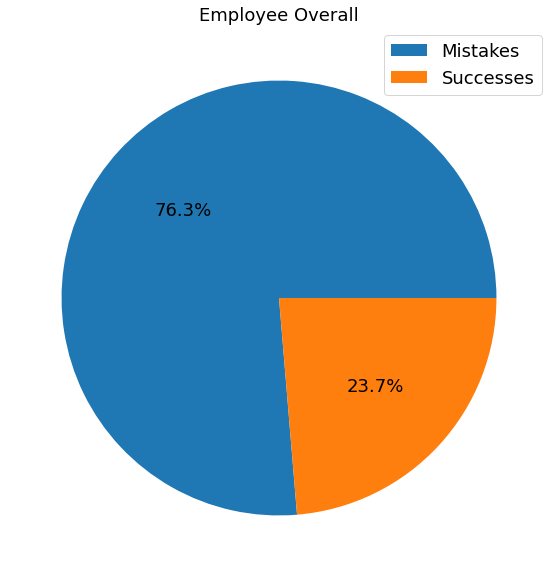

In [112]:
plt.pie([totalMistakes,totalSuccesses],autopct='%0.1f%%',textprops={'fontsize': 18}) 
plt.legend(labels=['Mistakes','Successes'],fontsize=18)
plt.title('Employee Overall',fontsize=18)
plt.show();